# Training transformers on generated datasets

## Examples

In [1]:
%matplotlib inline
import numpy as np

period = 24
def mysine(x, period):
    func1 = np.sin((2*np.pi/period)*x) # has a period of period
    func2 = np.sin((2*np.pi/15)*x) # has a period of period
    return func2 + func1

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]


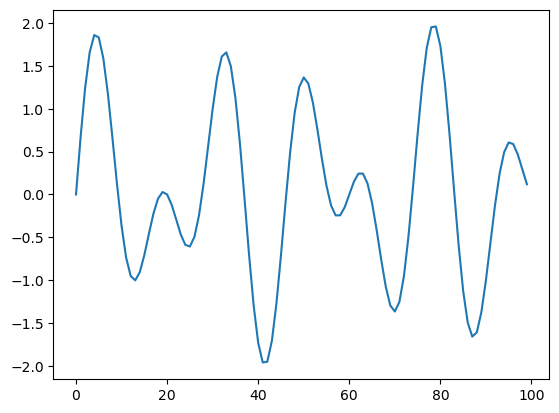

In [2]:
import matplotlib.pyplot as plt

max = 100
x = np.linspace(0, max - 1, num=max)
# x = range(0,30)
print(x)


def plot():
    plt.plot(mysine(x, period=24))
    plt.show()


plot()

In [3]:
import pandas as pd

no_points = 10000
period = 24
x = np.linspace(0, no_points - 1, num=no_points)
start_date = pd.Timestamp("2000-03-06")

data = {
    "date": pd.date_range("2000-03-06", periods=no_points, freq="D"),
    "OT": [mysine(ix, period=period) for ix in x],
}

df = pd.DataFrame(data)

In [4]:
df

,date,OT
0,2000-03-06,0.000000
1,2000-03-07,0.665556
2,2000-03-08,1.243145
3,2000-03-09,1.658163
4,2000-03-10,1.860547
...,...,...
9995,2027-07-18,1.124844
9996,2027-07-19,0.587785
9997,2027-07-20,-0.050907
9998,2027-07-21,-0.707912


In [5]:
def save_df_to_csv(df, name):
    root = "/Users/angelavansprang/Documents/PhD/transformers for time series/Autoformer/dataset/generated/"
    df.to_csv(root + name + ".csv", encoding="utf-8", index=False)


# save_df_to_csv(df, "sinusoidal")

## Generate your own data

In [6]:
%matplotlib inline
import inspect
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# CHANGE THE FUNCTION TO GENERATE THE DATA HERE
def function(x):
    func1 = np.sin((2*np.pi/7)*x) # has a period of 7
    func2 = np.sin((2*np.pi/30)*x) # has a period of 30
    func = func1 + func2

    return func

def make_dataset(name, function, save = False):
    """
    name: the name under which the .csv file will be stored
    """
    no_per_x = 3

    max = 100
    x = np.linspace(0, max-1, num=no_per_x*max)

    plt.plot(function(x))
    plt.suptitle(name)
    plt.show()

    no_points = int(10000/no_per_x)
    x = np.linspace(0,no_points-1, num=no_per_x*no_points)
    start_date = pd.Timestamp("2000-03-06")

    data = {
        "date": pd.date_range(start_date, periods = no_per_x*no_points, freq="D"),
        "OT": [function(ix) for ix in x]
    }

    df = pd.DataFrame(data)

    if save: 
        root = "/Users/angelavansprang/Documents/PhD/transformers for time series/Autoformer/dataset/generated/"
        df.to_csv(root + name + ".csv", encoding="utf-8", index=False)

        f = open(root + name + ".txt", "w")
        f.write(inspect.getsource(function))
        f.close()

# make_dataset(name = 'sinus7 + sinus30', function = function, save=True)

## Evaluating trained models

Make sure to have trained new models on your newly generated data from above elsewhere, and upload them to the correct folder.

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

import sys

sys.path.append("..")

In [8]:
from models import Autoformer
from utils.tools import dotdict
import torch


def obtain_autoformer(pred_len, dataset):
    # dataset = [sinusoidal]
    assert pred_len in [96, 192, 336, 720]

    args = dotdict()
    args.pred_len = pred_len

    args.enc_in = 1
    args.dec_in = 1
    args.c_out = 1

    args.label_len = 48

    args.target = "OT"
    args.des = "train"
    args.dropout = 0.05
    args.num_workers = 10
    args.gpu = 0
    args.lradj = "type1"
    args.devices = "0"
    args.use_gpu = False
    args.use_multi_gpu = False
    args.freq = "h"
    args.checkpoints = "./checkpoints/"
    args.bucket_size = 4
    args.n_hashes = 4
    args.is_trainging = True
    args.data = "custom"
    args.features = "M"
    args.seq_len = 96
    # args.label_len = 48
    args.e_layers = 2
    args.d_layers = 1
    args.n_heads = 8
    args.factor = 1
    args.d_model = 512
    args.des = "Exp"
    args.itr = 1
    args.d_ff = 2048
    args.moving_avg = 25
    args.factor = 1
    args.distil = True
    args.output_attention = True  # in order to save hooks
    args.embed = "timeF"

    autoformer_path = f"/Users/angelavansprang/Documents/PhD/transformers for time series/Autoformer/checkpoints/{dataset}_96_{pred_len}_Autoformer_{'ETTm2' if dataset == 'ETTm2' else 'custom'}_ftS_sl96_ll{'96' if dataset == 'ETTm2' else '48'}_pl{pred_len}_dm512_nh8_el2_dl1_df2048_fc{args.factor}_ebtimeF_dtTrue_Exp_0/checkpoint.pth"

    autoformer = Autoformer.Model(args).float()
    autoformer.load_state_dict(
        torch.load(autoformer_path, map_location=torch.device("cpu"))
    )

    autoformer.eval()

    return autoformer

In [9]:
autoformer_7 = obtain_autoformer(pred_len=96, dataset="sinus7")

In [10]:
from data_provider.data_loader import Dataset_Custom
from torch.utils.data import DataLoader


def obtain_data_loader(pred_len, dataset, seq_len=96, split="train"):
    label_len = 48

    data_set_electricity = Dataset_Custom(
        root_path="/Users/angelavansprang/Documents/PhD/transformers for time series/Autoformer/dataset/generated/",
        data_path=f"{dataset}.csv",
        flag=split,  # flag must be train in order for the linear dataloader to contain the same data
        size=[seq_len, label_len, pred_len],  # seq_len, label_len, pred_len
        features="S",
        target="OT",  # default
        timeenc=1,
        freq="h",
    )

    data_loader_electricity = DataLoader(
        data_set_electricity,
        batch_size=1,
        shuffle=False,
        num_workers=0,
        drop_last=False,
    )
    return data_loader_electricity

In [11]:
data_loader_7 = obtain_data_loader(pred_len=96, dataset="sinus7")

In [12]:
label_len = 48


def obtain_plot_predictions(
    pred_len,
    data_set,
    data_loader,
    model,
    item=0,
    alpha_gt=1,
    alpha_pred=0.5,
    vlines=[],
):
    with torch.no_grad():
        for i, (seq_x, seq_y, seq_x_mark, seq_y_mark) in enumerate(data_loader):
            if i == item:
                # seq_x is batch_size x seq_len x N_timeseries
                # seq_y is batch_size x label_len x N_timeseries
                # seq_x_mark is batch_size x seq_len X N_timefeatures
                # seq_y_mark is batch_size x (label_len+pred_len) X N_timefeatures

                print(seq_x.shape)
                print(seq_y.shape)
                print(seq_x_mark.shape)
                print(seq_y_mark.shape)

                # decoder input
                dec_inp = torch.zeros_like(seq_y[:, -pred_len:, :]).float()
                dec_inp = torch.cat([seq_y[:, :label_len, :], dec_inp], dim=1).float()

                # gt = np.concatenate((seq_x[0, :, 0], seq_y[0, -pred_len:, 0]), axis=0)
                gt = np.concatenate((seq_x[0, :, -1], seq_y[0, -pred_len:, -1]), axis=0)

                outputs_autoformer, _ = model(
                    seq_x.float(), seq_x_mark.float(), dec_inp, seq_y_mark.float()
                )
                pd_autoformer = np.concatenate(
                    (
                        [np.nan for i in range(seq_x.shape[1])],
                        outputs_autoformer[0, -pred_len:, -1],
                    ),
                    axis=0,
                )
                # pd_autoformer = np.concatenate((seq_x[0, :, 0], outputs_autoformer[0, -pred_len:, 0]), axis=0)

                plt.plot(gt, label="ground truth", color="black", alpha=alpha_gt)
                plt.plot(pd_autoformer, label="autoformer", alpha=alpha_pred)

                for vline in vlines:
                    plt.axvline(x=vline, color="b", linestyle="--")

                plt.legend()
                plt.xlabel("Data points")
                plt.ylabel("Scaled time series")
                plt.suptitle(data_set)
                # plt.suptitle("top-k time delay sizes of auto-correlation decoder")
                # plt.suptitle(f"{'Energy consumption' if data_set=='ECL' else (f'Daily exchange rate (country {time_series_id})' if data_set=='Exchange' else '')} forecasting with prediction length {pred_len}")
                plt.show()

torch.Size([1, 96, 1])
torch.Size([1, 144, 1])
torch.Size([1, 96, 4])
torch.Size([1, 144, 4])


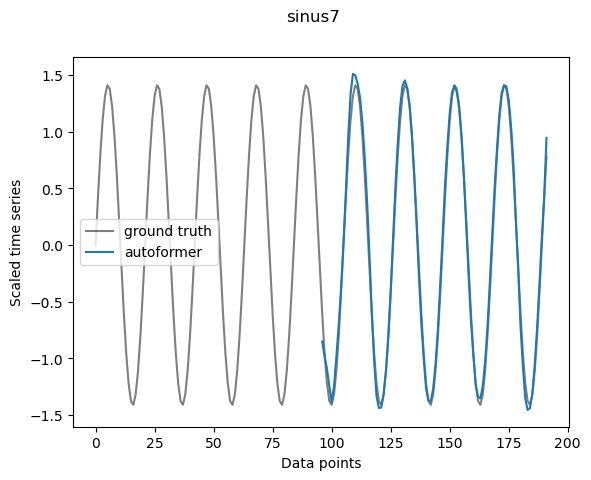

In [13]:
%matplotlib inline
obtain_plot_predictions(96, "sinus7", data_loader_7, autoformer_7, item = 0, alpha_gt = 0.5, alpha_pred = 1)

torch.Size([1, 96, 1])
torch.Size([1, 144, 1])
torch.Size([1, 96, 4])
torch.Size([1, 144, 4])


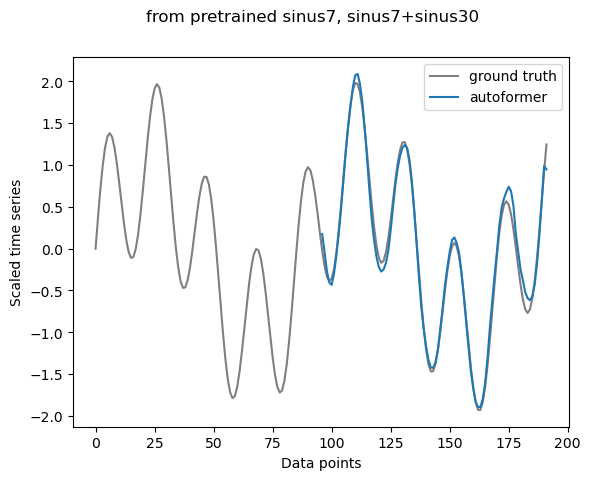

In [14]:
finetuned_autoformer_730 = obtain_autoformer(
    pred_len=96, dataset="init_from_sinus7_train_on_sinus7+sinus30"
)
# data_loader_730 = obtain_data_loader(pred_len=96, dataset="sinus7")
data_loader_730 = obtain_data_loader(pred_len=96, dataset="sinus7+sinus30")
obtain_plot_predictions(
    96,
    "from pretrained sinus7, sinus7+sinus30",
    data_loader_730,
    finetuned_autoformer_730,
    item=0,
    alpha_gt=0.5,
    alpha_pred=1,
    vlines=[],
)

torch.Size([1, 96, 1])
torch.Size([1, 144, 1])
torch.Size([1, 96, 4])
torch.Size([1, 144, 4])


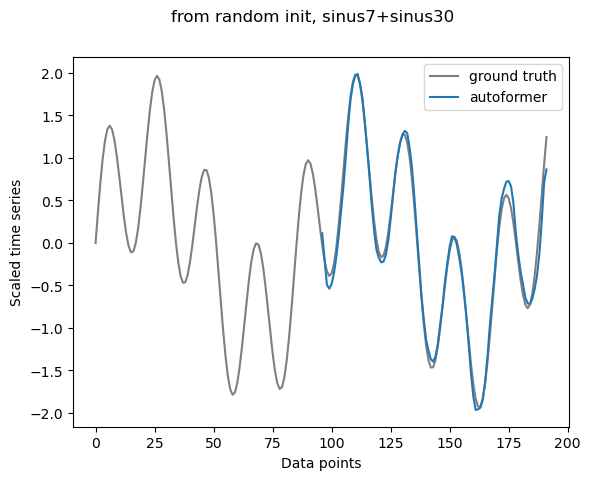

In [15]:
autoformer_730 = obtain_autoformer(pred_len=96, dataset="sinus7+sinus30")
# data_loader_730 = obtain_data_loader(pred_len=96, dataset="sinus7+sinus30")
obtain_plot_predictions(
    96,
    "from random init, sinus7+sinus30",
    data_loader_730,
    autoformer_730,
    item=0,
    alpha_gt=0.5,
    alpha_pred=1,
    vlines=[],
)

## Investigate autoformer

In [16]:
autoformer_730

Model(
  (decomp): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encode

In [17]:
autoformer_730.encoder.attn_layers

ModuleList(
  (0-1): 2 x EncoderLayer(
    (attention): AutoCorrelationLayer(
      (inner_correlation): AutoCorrelation(
        (dropout): Dropout(p=0.05, inplace=False)
      )
      (query_projection): Linear(in_features=512, out_features=512, bias=True)
      (key_projection): Linear(in_features=512, out_features=512, bias=True)
      (value_projection): Linear(in_features=512, out_features=512, bias=True)
      (out_projection): Linear(in_features=512, out_features=512, bias=True)
      (individual_heads): HookPoint()
      (attn_weights): HookPoint()
      (value_vectors): HookPoint()
    )
    (conv1): Conv1d(512, 2048, kernel_size=(1,), stride=(1,), bias=False)
    (conv2): Conv1d(2048, 512, kernel_size=(1,), stride=(1,), bias=False)
    (decomp1): series_decomp(
      (moving_avg): moving_avg(
        (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
      )
    )
    (decomp2): series_decomp(
      (moving_avg): moving_avg(
        (avg): AvgPool1d(kernel_size=(

## Run the model on different inputs and save the activations

In [18]:
# TODO: FIND ALL RELEVANT LOCATIONS FROM WHICH TO STORE THE ACTIVATIONS (see locations wav2vec)
# How to store the values from all the individual heads?

In [19]:
from collections import defaultdict


def get_activations_for_dataset(model, stimuli: list, pred_len=96):
    # Create a list of dictionaries to store the activations of each sample.
    activations = []

    def reset_activations():
        # Reset the activations for a new sample.
        activations.append(
            {
                "value_vectors": defaultdict(list),
                "individual_heads": defaultdict(list),
                "attention_weights": defaultdict(list),
                "attention.query_projection": defaultdict(list),
                "attention.key_projection": defaultdict(list),
                "attention.value_projection": defaultdict(list),
                "attention.out_projection": defaultdict(list),
            }
        )

    def value_vectors_hook(layer_id):
        def hook(module, input, output):
            activations[-1]["value_vectors"][layer_id].append(output.detach())

        return hook

    def attention_hook(layer_id):
        def hook(module, input, output):
            activations[-1]["individual_heads"][layer_id].append(output.detach())

        return hook

    def attention_weights_hook(layer_id):
        def hook(module, input, output):
            activations[-1]["attention_weights"][layer_id].append(output.detach())

        return hook

    def attention_query_projection(layer_id):
        def hook(module, input, output):
            activations[-1]["attention.query_projection"][layer_id].append(
                output.detach()
            )

        return hook

    def attention_key_projection(layer_id):
        def hook(module, input, output):
            activations[-1]["attention.key_projection"][layer_id].append(
                output.detach()
            )

        return hook

    def attention_value_projection(layer_id):
        def hook(module, input, output):
            activations[-1]["attention.value_projection"][layer_id].append(
                output.detach()
            )

        return hook

    def attention_out_projection(layer_id):
        def hook(module, input, output):
            activations[-1]["attention.out_projection"][layer_id].append(
                output.detach()
            )

        return hook

    # Register the hooks.
    for i, layer in enumerate(model.encoder.attn_layers):
        print("start", activations)
        layer.attention.value_vectors.register_forward_hook(value_vectors_hook(i))
        layer.attention.individual_heads.register_forward_hook(attention_hook(i))
        layer.attention.attn_weights.register_forward_hook(attention_weights_hook(i))
        layer.attention.key_projection.register_forward_hook(
            attention_key_projection(i)
        )
        layer.attention.value_projection.register_forward_hook(
            attention_value_projection(i)
        )
        layer.attention.query_projection.register_forward_hook(
            attention_query_projection(i)
        )
        layer.attention.out_projection.register_forward_hook(
            attention_out_projection(i)
        )

    # Go through your dataset and compute the forward passes.
    # res = []
    for (
        seq_x,
        seq_y,
        seq_x_mark,
        seq_y_mark,
    ) in stimuli:  # stimulus as returned by dataloader
        reset_activations()
        print(activations)
        torch.manual_seed(42)
        # raw_waveform, sr = librosa.load(s, sr=16000)
        # input = processor(
        #     raw_waveform,
        #     sampling_rate=16000,
        #     return_tensors="pt",
        #     padding="max_length",
        #     max_length=1000,
        # ).input_values.to(DEVICE)
        # output_dict = model(input, output_attentions=True, output_hidden_states=True)
        # hidden_states_before_intervention = output_dict.hidden_states
        # logits = output_dict.logits[0]
        # res.append(logits)

        # decoder input
        dec_inp = torch.zeros_like(seq_y[:, -pred_len:, :]).float()
        dec_inp = torch.cat([seq_y[:, :label_len, :], dec_inp], dim=1).float()
        outputs_autoformer = model(
            seq_x.float(), seq_x_mark.float(), dec_inp, seq_y_mark.float()
        )

    # Unregister the hooks to make sure they don't interfere with the next dataset.
    for i, layer in enumerate(model.encoder.attn_layers):
        layer.attention.value_vectors._forward_hooks.clear()
        layer.attention.individual_heads._forward_hooks.clear()
        layer.attention.attn_weights._forward_hooks.clear()
        layer.attention.key_projection._forward_hooks.clear()
        layer.attention.value_projection._forward_hooks.clear()
        layer.attention.query_projection._forward_hooks.clear()
        layer.attention.out_projection._forward_hooks.clear()

    return activations

In [20]:
for i, layer in enumerate(autoformer_7.encoder.attn_layers):
    layer.attention.value_vectors._forward_hooks.clear()
    layer.attention.individual_heads._forward_hooks.clear()
    layer.attention.attn_weights._forward_hooks.clear()
    layer.attention.key_projection._forward_hooks.clear()
    layer.attention.value_projection._forward_hooks.clear()
    layer.attention.query_projection._forward_hooks.clear()
    layer.attention.out_projection._forward_hooks.clear()

torch.Size([1, 96, 1])
torch.Size([1, 144, 1])
torch.Size([1, 96, 4])
torch.Size([1, 144, 4])
start []
start []
[{'value_vectors': defaultdict(<class 'list'>, {}), 'individual_heads': defaultdict(<class 'list'>, {}), 'attention_weights': defaultdict(<class 'list'>, {}), 'attention.query_projection': defaultdict(<class 'list'>, {}), 'attention.key_projection': defaultdict(<class 'list'>, {}), 'attention.value_projection': defaultdict(<class 'list'>, {}), 'attention.out_projection': defaultdict(<class 'list'>, {})}]


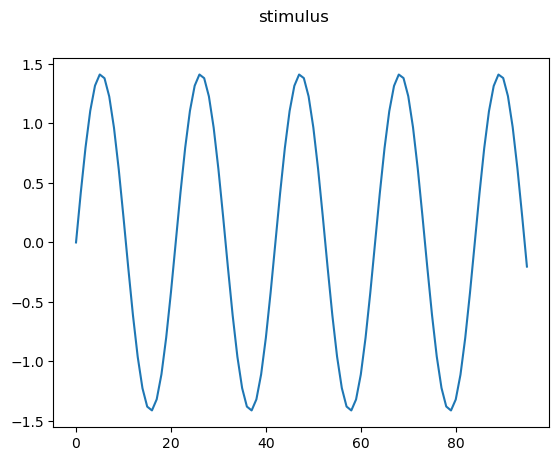

In [21]:
for stimulus in data_loader_7:
    seq_x, seq_y, seq_x_mark, seq_y_mark = stimulus
    print(seq_x.shape)
    print(seq_y.shape)
    print(seq_x_mark.shape)
    print(seq_y_mark.shape)
    plt.plot(seq_x[0, :, -1])
    plt.suptitle("stimulus")
    break

activations = get_activations_for_dataset(model=autoformer_7, stimuli=[stimulus])

# stimulus =

In [60]:
for key in activations[-1].keys():
    print(key, activations[-1][key][0][0].shape)

value_vectors torch.Size([1, 96, 8, 64])
individual_heads torch.Size([1, 96, 8, 64])
attention_weights torch.Size([1, 96, 8, 64])
attention.query_projection torch.Size([1, 96, 512])
attention.key_projection torch.Size([1, 96, 512])
attention.value_projection torch.Size([1, 96, 512])
attention.out_projection torch.Size([1, 96, 512])


In [23]:
activations[-1]["attention.query_projection"][0][0].shape

torch.Size([1, 96, 512])

In [24]:
activations[-1].keys()

dict_keys(['value_vectors', 'individual_heads', 'attention_weights', 'attention.query_projection', 'attention.key_projection', 'attention.value_projection', 'attention.out_projection'])

## Centered Kernel Alignment

In [25]:
# Code from https://github.com/yuanli2333/CKA-Centered-Kernel-Alignment/tree/master

import math
import numpy as np


def centering(K):
    n = K.shape[0]
    unit = np.ones([n, n])
    I = np.eye(n)
    H = I - unit / n

    return np.dot(
        np.dot(H, K), H
    )  # HKH are the same with KH, KH is the first centering, H(KH) do the second time, results are the sme with one time centering
    # return np.dot(H, K)  # KH


def rbf(X, sigma=None):
    GX = np.dot(X, X.T)
    KX = np.diag(GX) - GX + (np.diag(GX) - GX).T
    if sigma is None:
        mdist = np.median(KX[KX != 0])
        sigma = math.sqrt(mdist)
    KX *= -0.5 / (sigma * sigma)
    KX = np.exp(KX)
    return KX


def kernel_HSIC(X, Y, sigma):
    return np.sum(centering(rbf(X, sigma)) * centering(rbf(Y, sigma)))


def linear_HSIC(X, Y):
    L_X = np.dot(X, X.T)
    L_Y = np.dot(Y, Y.T)
    return np.sum(centering(L_X) * centering(L_Y))


def linear_CKA(X, Y):
    hsic = linear_HSIC(X, Y)
    var1 = np.sqrt(linear_HSIC(X, X))
    var2 = np.sqrt(linear_HSIC(Y, Y))

    return hsic / (var1 * var2)


def kernel_CKA(X, Y, sigma=None):
    hsic = kernel_HSIC(X, Y, sigma)
    var1 = np.sqrt(kernel_HSIC(X, X, sigma))
    var2 = np.sqrt(kernel_HSIC(Y, Y, sigma))

    return hsic / (var1 * var2)

In [63]:
# Test CKA

import numpy as np
import pickle
import gzip
import cca_core

X = np.random.randn(100, 64)
Y = np.random.randn(100, 64)

print("Linear CKA, between X and Y: {}".format(linear_CKA(X, Y)))
print("Linear CKA, between X and X: {}".format(linear_CKA(X, X)))

print("RBF Kernel CKA, between X and Y: {}".format(kernel_CKA(X, Y)))
print("RBF Kernel CKA, between X and X: {}".format(kernel_CKA(X, X)))

Linear CKA, between X and Y: 0.3853449263625884
Linear CKA, between X and X: 0.9999999999999998
Linear CKA, between X and Y: 0.606402413706046
Linear CKA, between X and X: 1.0
RBF Kernel CKA, between X and Y: 0.5170981498411578
RBF Kernel CKA, between X and X: 1.0


In [62]:
X = activations[-1]["attention.key_projection"][0][0].squeeze().numpy()
Y = activations[-1]["attention.key_projection"][1][0].squeeze().numpy()
print(X.shape, Y.shape)
print(linear_CKA(X, Y))

X = activations[-1]["attention.key_projection"][0][0].squeeze().numpy()
Y = activations[-1]["attention.key_projection"][1][0].squeeze().numpy()
print(X.T.shape, Y.T.shape)
print(linear_CKA(X.T, Y.T))

X = activations[-1]["attention.value_projection"][0][0].squeeze().numpy()
Y = activations[-1]["attention.value_projection"][1][0].squeeze().numpy()
print(X.shape, Y.shape)
print(linear_CKA(X, Y))

X = activations[-1]["attention.query_projection"][0][0].squeeze().numpy()
Y = activations[-1]["attention.query_projection"][1][0].squeeze().numpy()
print(X.shape, Y.shape)
print(linear_CKA(X, Y))

X = activations[-1]["attention.out_projection"][0][0].squeeze().numpy()
Y = activations[-1]["attention.out_projection"][1][0].squeeze().numpy()
print(X.shape, Y.shape)
print(linear_CKA(X, Y))

(96, 512) (96, 512)
0.9813994688436123
(512, 96) (512, 96)
0.0008005345964401555
(96, 512) (96, 512)
0.9740870933247441
(96, 512) (96, 512)
0.9649587155053889
(96, 512) (96, 512)
0.17253209942612588


In [28]:
autoformer_7_seed2021 = obtain_autoformer(pred_len=96, dataset="sinus7")
autoformer_7_seed42 = obtain_autoformer(pred_len=96, dataset="seed42_sinus7")

data_loader_7 = obtain_data_loader(pred_len=96, dataset="sinus7")

torch.Size([1, 96, 1])
torch.Size([1, 144, 1])
torch.Size([1, 96, 4])
torch.Size([1, 144, 4])
start []
start []
[{'value_vectors': defaultdict(<class 'list'>, {}), 'individual_heads': defaultdict(<class 'list'>, {}), 'attention_weights': defaultdict(<class 'list'>, {}), 'attention.query_projection': defaultdict(<class 'list'>, {}), 'attention.key_projection': defaultdict(<class 'list'>, {}), 'attention.value_projection': defaultdict(<class 'list'>, {}), 'attention.out_projection': defaultdict(<class 'list'>, {})}]
start []
start []
[{'value_vectors': defaultdict(<class 'list'>, {}), 'individual_heads': defaultdict(<class 'list'>, {}), 'attention_weights': defaultdict(<class 'list'>, {}), 'attention.query_projection': defaultdict(<class 'list'>, {}), 'attention.key_projection': defaultdict(<class 'list'>, {}), 'attention.value_projection': defaultdict(<class 'list'>, {}), 'attention.out_projection': defaultdict(<class 'list'>, {})}]


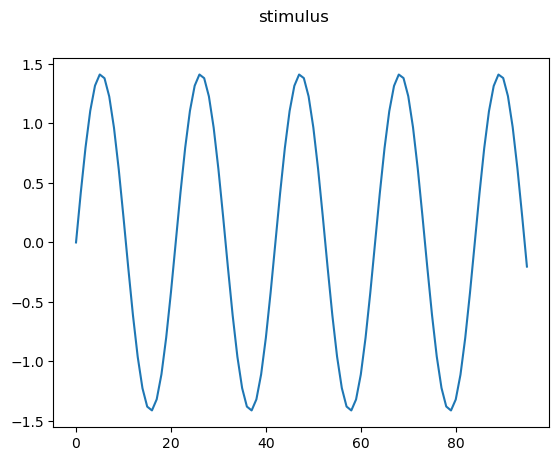

In [29]:
for stimulus in data_loader_7:
    seq_x, seq_y, seq_x_mark, seq_y_mark = stimulus
    print(seq_x.shape)
    print(seq_y.shape)
    print(seq_x_mark.shape)
    print(seq_y_mark.shape)
    plt.plot(seq_x[0, :, -1])
    plt.suptitle("stimulus")
    break

activations_seed2021 = get_activations_for_dataset(
    model=autoformer_7_seed2021, stimuli=[stimulus]
)
activations_seed42 = get_activations_for_dataset(
    model=autoformer_7_seed42, stimuli=[stimulus]
)

In [30]:
activations_seed2021[-1]["individual_heads"][0][0].shape

torch.Size([1, 96, 8, 64])

In [31]:
len(activations_seed2021[-1]["individual_heads"][0][0].squeeze().numpy().shape)

3

In [32]:
layer = 0
head = 0

"layer" + str(layer) + "_head" + str(head)

'layer0_head0'

In [33]:
hi = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
hi
hi[0, :]

array([1, 2, 3])

In [34]:
# Obtain CKA heatmaps for activations per layer


def obtain_CKA_heatmaps_layerwise(
    activations1, activations2, modelnames, type="linear"
):
    results = defaultdict(defaultdict)
    descriptions = defaultdict(defaultdict)
    for component in activations1[-1].keys():
        print("start with component: ", component)
        for layer in activations1[-1][component].keys():
            print(" layer: ", layer)
            X = (
                activations1[-1][component][layer][0].squeeze().numpy()
            )  # note that there could be more tensors here with more stimuli, then cannot just use index 0
            print(" shape: ", X.shape)
            if len(X.shape) == 3:
                for head in range(8):
                    results[component]["layer" + str(layer) + "_head" + str(head)] = []
                    descriptions[component][
                        "layer" + str(layer) + "_head" + str(head)
                    ] = []
            else:
                results[component]["layer" + str(layer)] = []
                descriptions[component]["layer" + str(layer)] = []
            for comparison_layer in activations2[-1][component].keys():
                # print("comparison_layer: ", comparison_layer)
                Y = activations2[-1][component][comparison_layer][0].squeeze().numpy()

                if len(X.shape) == 3:  # we have activations per head
                    for head_x in range(8):
                        # print("head_x: ", head_x)
                        X_i = X[:, head_x, :]
                        for head_y in range(8):
                            # print("head_y: ", head_y)
                            Y_i = Y[:, head_y, :]

                            if type == "linear":
                                score = linear_CKA(X_i, Y_i)
                            elif type == "kernel":
                                score = kernel_CKA(X_i, Y_i)

                            results[component][
                                "layer" + str(layer) + "_head" + str(head_x)
                            ].append(score)
                            descriptions[component][
                                "layer" + str(layer) + "_head" + str(head_x)
                            ].append(
                                "layer" + str(comparison_layer) + "_head" + str(head_y)
                            )

                else:
                    if type == "linear":
                        score = linear_CKA(X, Y)
                    elif type == "kernel":
                        score = kernel_CKA(X, Y)

                    results[component]["layer" + str(layer)].append(score)
                    descriptions[component]["layer" + str(layer)].append(
                        "layer" + str(comparison_layer)
                    )
        d = results[component]
        results[component] = dict(sorted(d.items(), reverse=True))
    return results, descriptions, modelnames


scores, descriptions, modelnames = obtain_CKA_heatmaps_layerwise(
    activations_seed2021,
    activations_seed42,
    modelnames=["autoformer_seed2021", "autoformer_seed42"],
    type="linear",
)
print(scores)

# update through
# B: 1, L: 144, S: 96, H: 8

start with component:  value_vectors
 layer:  0
 shape:  (96, 8, 64)
 layer:  1
 shape:  (96, 8, 64)
start with component:  individual_heads
 layer:  0
 shape:  (96, 8, 64)
 layer:  1
 shape:  (96, 8, 64)
start with component:  attention_weights
 layer:  0
 shape:  (96, 8, 64)
 layer:  1
 shape:  (96, 8, 64)
start with component:  attention.query_projection
 layer:  0
 shape:  (96, 512)
 layer:  1
 shape:  (96, 512)
start with component:  attention.key_projection
 layer:  0
 shape:  (96, 512)
 layer:  1
 shape:  (96, 512)
start with component:  attention.value_projection
 layer:  0
 shape:  (96, 512)
 layer:  1
 shape:  (96, 512)
start with component:  attention.out_projection
 layer:  0
 shape:  (96, 512)
 layer:  1
 shape:  (96, 512)
defaultdict(<class 'collections.defaultdict'>, {'value_vectors': {'layer1_head7': [0.9676136624974907, 0.9673835826236937, 0.9697677172249649, 0.9665347733713806, 0.9727708916932404, 0.9661188760726298, 0.9637489690440012, 0.9708386809744878, 0.986775739

In [35]:
len(scores["individual_heads"]["layer0_head7"])

16

TODO: THERE ARE too many values in the dictionaries. Make sure that the calculation of all combinations of heads goes well. Perhaps should think of another to write it? Check the for-loops, in principle it looks okay I think. Also think about how to store all values well. 

In [36]:
scores

defaultdict(collections.defaultdict,
            {'value_vectors': {'layer1_head7': [0.9676136624974907,
               0.9673835826236937,
               0.9697677172249649,
               0.9665347733713806,
               0.9727708916932404,
               0.9661188760726298,
               0.9637489690440012,
               0.9708386809744878,
               0.9867757390449206,
               0.9856843203594199,
               0.9936054221549783,
               0.9927584447254483,
               0.9913606378673068,
               0.9870347682091799,
               0.9946365336368245,
               0.9897380092002738],
              'layer1_head6': [0.9665936551660934,
               0.9653089976808029,
               0.9688134388512318,
               0.967664647957486,
               0.9718376535480513,
               0.9641747805771974,
               0.9650539481799663,
               0.9686159445100601,
               0.9851511502942273,
               0.9864916272561689,
    

In [37]:
descriptions

defaultdict(collections.defaultdict,
            {'value_vectors': defaultdict(None,
                         {'layer0_head0': ['layer0_head0',
                           'layer0_head1',
                           'layer0_head2',
                           'layer0_head3',
                           'layer0_head4',
                           'layer0_head5',
                           'layer0_head6',
                           'layer0_head7',
                           'layer1_head0',
                           'layer1_head1',
                           'layer1_head2',
                           'layer1_head3',
                           'layer1_head4',
                           'layer1_head5',
                           'layer1_head6',
                           'layer1_head7'],
                          'layer0_head1': ['layer0_head0',
                           'layer0_head1',
                           'layer0_head2',
                           'layer0_head3',
                      

In [38]:
list(scores["attention.query_projection"].values())

[[0.9688680507517029, 0.9712817628714294],
 [0.9996118251385568, 0.9648004412761442]]

In [39]:
list(scores["attention.query_projection"].keys())

['layer1', 'layer0']

In [40]:
descriptions["individual_heads"]

defaultdict(None,
            {'layer0_head0': ['layer0_head0',
              'layer0_head1',
              'layer0_head2',
              'layer0_head3',
              'layer0_head4',
              'layer0_head5',
              'layer0_head6',
              'layer0_head7',
              'layer1_head0',
              'layer1_head1',
              'layer1_head2',
              'layer1_head3',
              'layer1_head4',
              'layer1_head5',
              'layer1_head6',
              'layer1_head7'],
             'layer0_head1': ['layer0_head0',
              'layer0_head1',
              'layer0_head2',
              'layer0_head3',
              'layer0_head4',
              'layer0_head5',
              'layer0_head6',
              'layer0_head7',
              'layer1_head0',
              'layer1_head1',
              'layer1_head2',
              'layer1_head3',
              'layer1_head4',
              'layer1_head5',
              'layer1_head6',
              'laye

In [41]:
list(scores["individual_heads"].values())[0]

[0.45568515779006064,
 0.47093035250033005,
 0.44427878403452625,
 0.40871217399439363,
 0.44398964978642,
 0.4644371196266852,
 0.3950042514037501,
 0.4743267247669989,
 0.3683217574266354,
 0.35868113288141584,
 0.40224678537187203,
 0.3865271475054223,
 0.3847641161461027,
 0.3572696371713971,
 0.40638846985967036,
 0.3721618112967095]

In [42]:
scores["individual_heads"].values()

dict_values([[0.45568515779006064, 0.47093035250033005, 0.44427878403452625, 0.40871217399439363, 0.44398964978642, 0.4644371196266852, 0.3950042514037501, 0.4743267247669989, 0.3683217574266354, 0.35868113288141584, 0.40224678537187203, 0.3865271475054223, 0.3847641161461027, 0.3572696371713971, 0.40638846985967036, 0.3721618112967095], [0.45308164820816726, 0.468938500144223, 0.43837754760260744, 0.40298082644448, 0.43753102515319886, 0.46179938012027744, 0.3875181175560419, 0.47148549493835823, 0.34451712379054666, 0.3341448164887894, 0.3811077848883178, 0.3642943508533813, 0.3626113393425979, 0.33325040920312293, 0.38513595360063, 0.34897729186310145], [0.39833368869979097, 0.4149193165905306, 0.3818709478848088, 0.345537284284085, 0.3809101708362638, 0.40719300571381084, 0.3290748732823953, 0.41723937690890733, 0.3282150675336931, 0.3201208958801524, 0.3718636688274247, 0.35338872056750215, 0.35340260496895937, 0.32026626563979166, 0.37537408903655056, 0.33743814785886683], [0.431

In [43]:
test = [
    [
        1,
        1,
        1,
    ],
    [0, 0, 0],
    [0, 0, 0],
]

In [44]:
list(descriptions["individual_heads"].values())[0]

['layer0_head0',
 'layer0_head1',
 'layer0_head2',
 'layer0_head3',
 'layer0_head4',
 'layer0_head5',
 'layer0_head6',
 'layer0_head7',
 'layer1_head0',
 'layer1_head1',
 'layer1_head2',
 'layer1_head3',
 'layer1_head4',
 'layer1_head5',
 'layer1_head6',
 'layer1_head7']

In [45]:
range(len(list(descriptions["individual_heads"].values())[0]))

range(0, 16)

Are they plotted correctly, and why is not symmetrical?

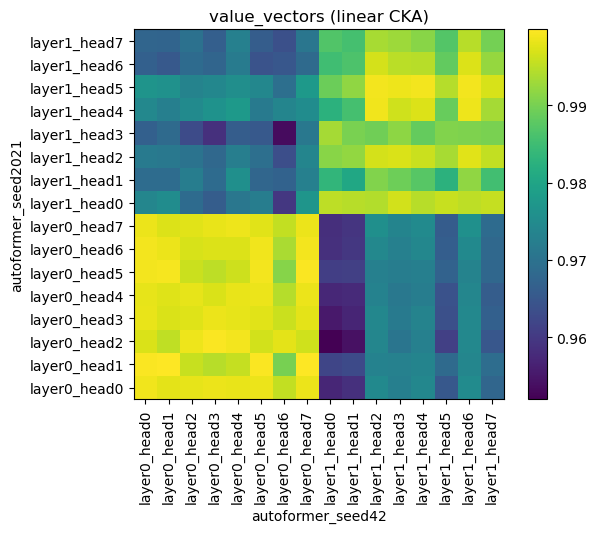

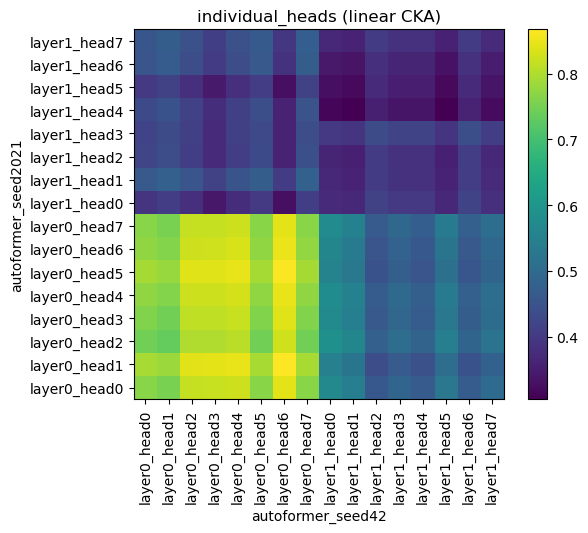

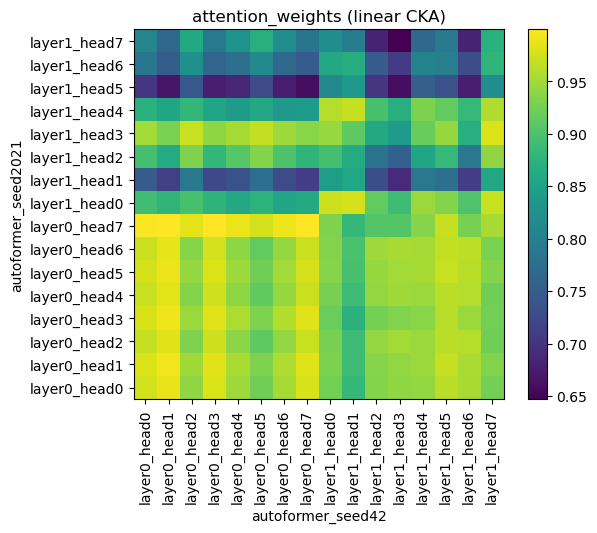

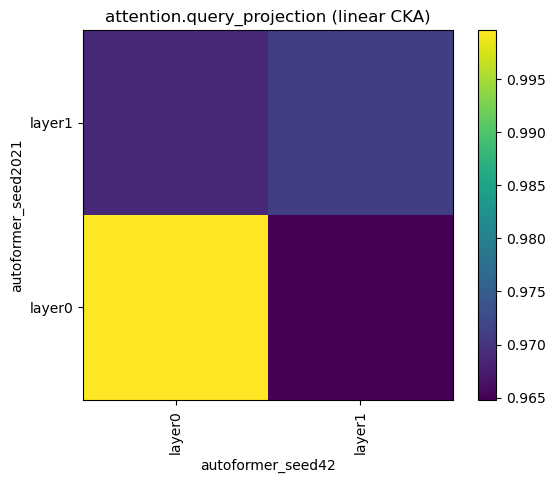

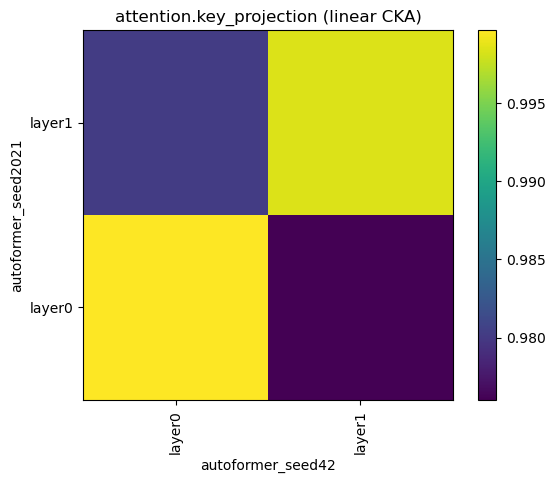

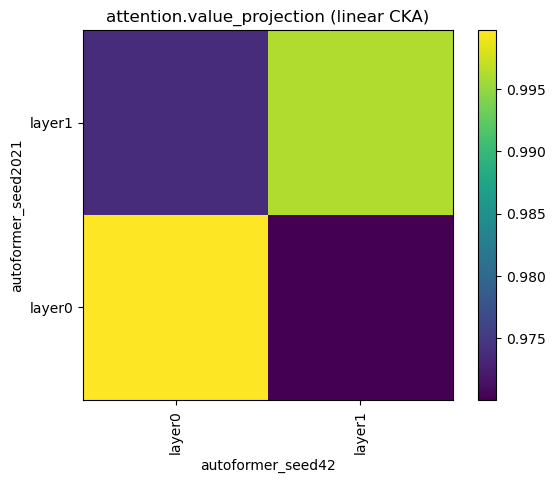

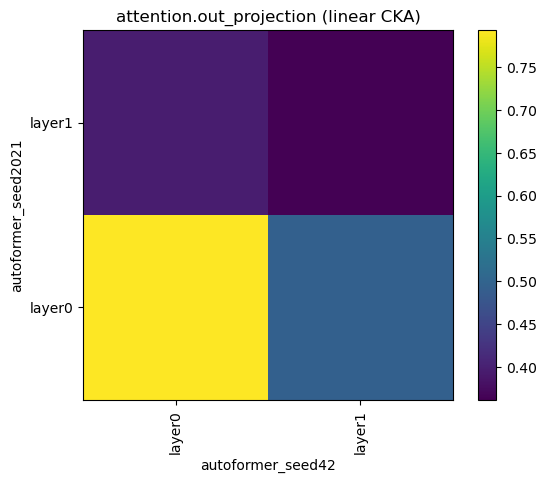

In [46]:
%matplotlib inline

def plot_CKA_heatmaps(scores, descriptions, modelnames, type="linear"):
    for component in scores.keys():
        if len(scores[component].values()) != 0: # if some hooks are not yet implemented, can be removed later
            plt.figure()
            plt.imshow(scores[component].values())
            # plt.imshow(test)
            plt.title(f"{component} ({type} CKA)")
            plt.colorbar()
            # plt.xaxis.set_ticks(np.arange(start, end, stepsize=1))
            # plt.xticks([0,1])
            plt.xticks(ticks = range(len(list(descriptions[component].values())[0])), labels = list(descriptions[component].values())[0], rotation = 90)
            # plt.yticks(ticks=list(scores[component].keys()), labels = list(scores[component].keys()))
            plt.yticks(ticks=range(len(list(scores[component].keys()))), labels = list(scores[component].keys()))
            plt.ylabel(modelnames[0])
            plt.xlabel(modelnames[1])

            # plt.yticks([1,0])


plot_CKA_heatmaps(scores, descriptions, modelnames, type="linear")

Question: if we train the same autoformer on the same data, but with a different seed, does this mean that the same heads learn the same stuff?
Answer: no, as can be seen from the plots below.

Follow-up question: if we set the seed to the same, does it mean that the heads are similar again?

start with component:  value_vectors
 layer:  0
 shape:  (96, 8, 64)
 layer:  1
 shape:  (96, 8, 64)
start with component:  individual_heads
 layer:  0
 shape:  (96, 8, 64)
 layer:  1
 shape:  (96, 8, 64)
start with component:  attention_weights
 layer:  0
 shape:  (96, 8, 64)
 layer:  1
 shape:  (96, 8, 64)
start with component:  attention.query_projection
 layer:  0
 shape:  (96, 512)
 layer:  1
 shape:  (96, 512)
start with component:  attention.key_projection
 layer:  0
 shape:  (96, 512)
 layer:  1
 shape:  (96, 512)
start with component:  attention.value_projection
 layer:  0
 shape:  (96, 512)
 layer:  1
 shape:  (96, 512)
start with component:  attention.out_projection
 layer:  0
 shape:  (96, 512)
 layer:  1
 shape:  (96, 512)


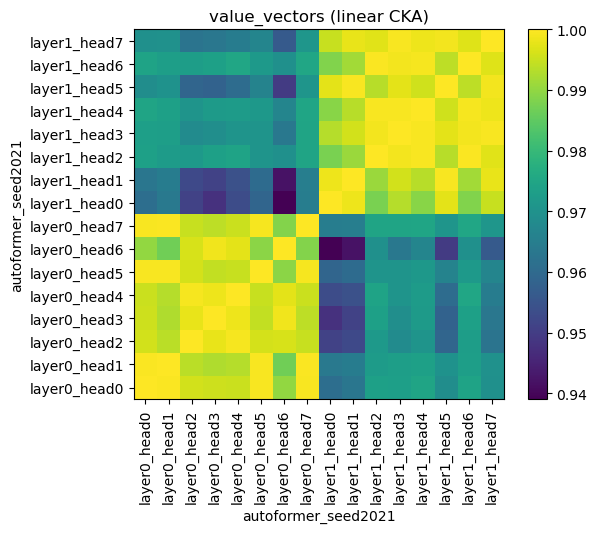

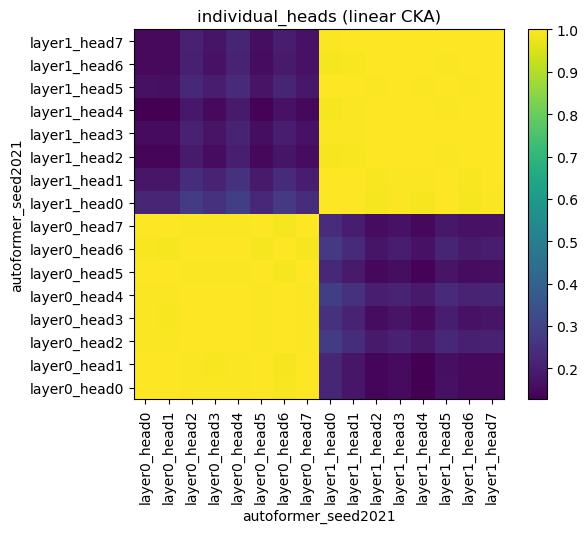

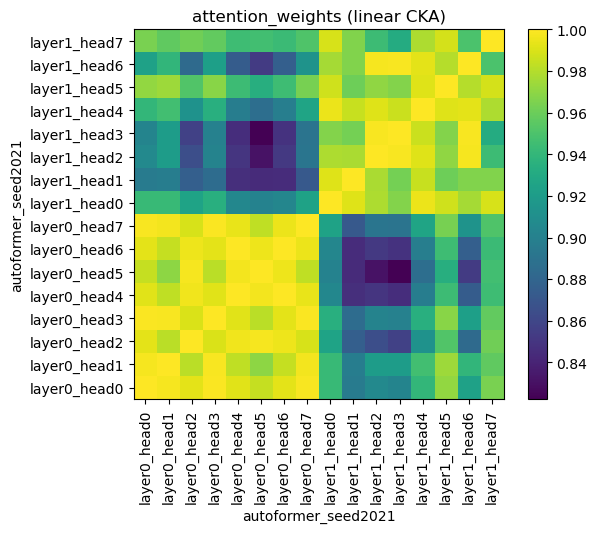

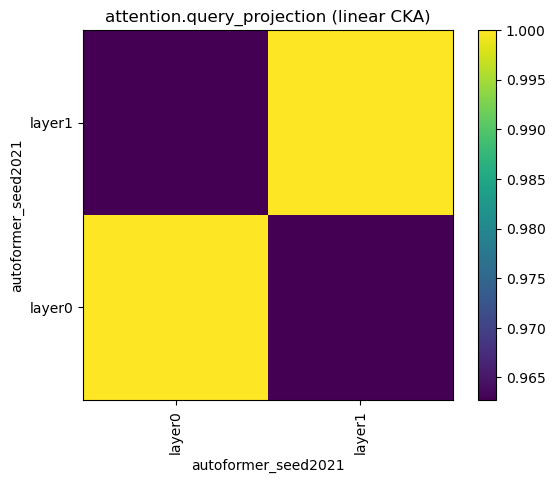

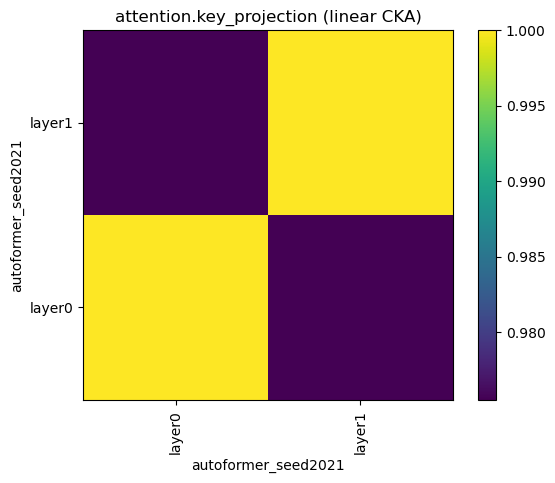

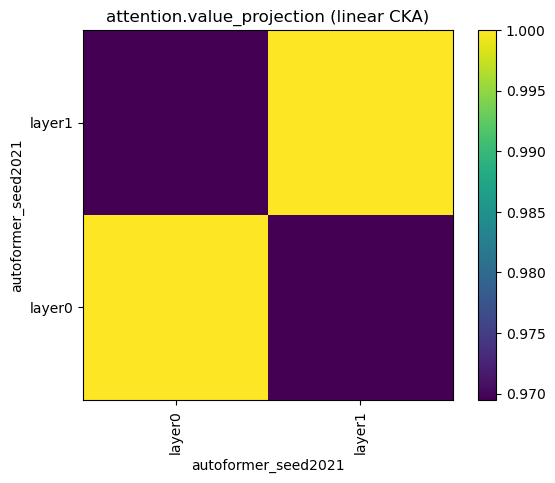

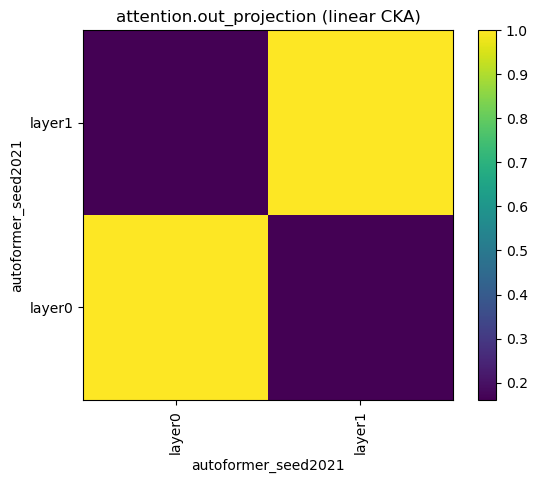

In [47]:
scores, descriptions, modelnames = obtain_CKA_heatmaps_layerwise(
    activations_seed42,
    activations_seed42,
    modelnames=["autoformer_seed2021", "autoformer_seed2021"],
    type="linear",
)
plot_CKA_heatmaps(scores, descriptions, modelnames, type="linear")

Follow-up question: if we set the seed to the same, does it mean that the heads are similar again?

Answer:

torch.Size([1, 96, 1])
torch.Size([1, 144, 1])
torch.Size([1, 96, 4])
torch.Size([1, 144, 4])
start []
start []
[{'value_vectors': defaultdict(<class 'list'>, {}), 'individual_heads': defaultdict(<class 'list'>, {}), 'attention_weights': defaultdict(<class 'list'>, {}), 'attention.query_projection': defaultdict(<class 'list'>, {}), 'attention.key_projection': defaultdict(<class 'list'>, {}), 'attention.value_projection': defaultdict(<class 'list'>, {}), 'attention.out_projection': defaultdict(<class 'list'>, {})}]
start []
start []
[{'value_vectors': defaultdict(<class 'list'>, {}), 'individual_heads': defaultdict(<class 'list'>, {}), 'attention_weights': defaultdict(<class 'list'>, {}), 'attention.query_projection': defaultdict(<class 'list'>, {}), 'attention.key_projection': defaultdict(<class 'list'>, {}), 'attention.value_projection': defaultdict(<class 'list'>, {}), 'attention.out_projection': defaultdict(<class 'list'>, {})}]
start with component:  value_vectors
 layer:  0
 shape

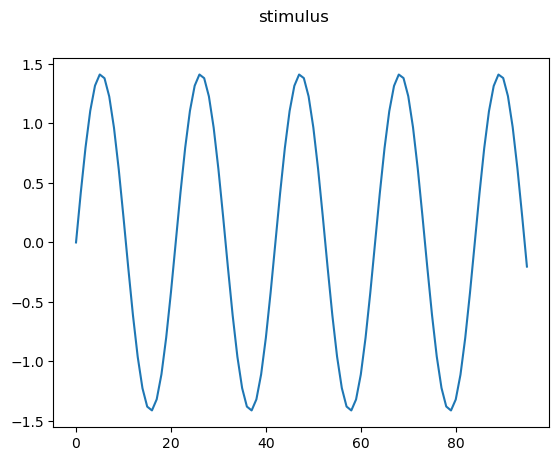

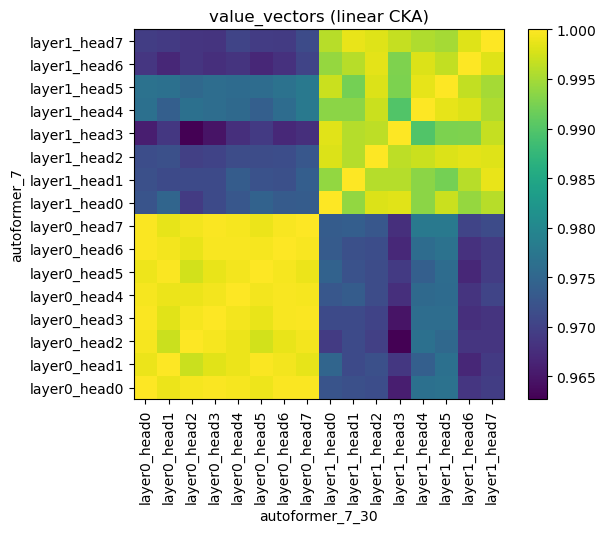

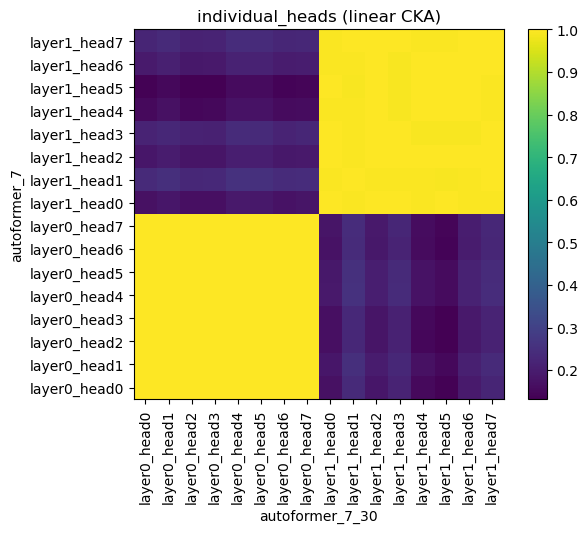

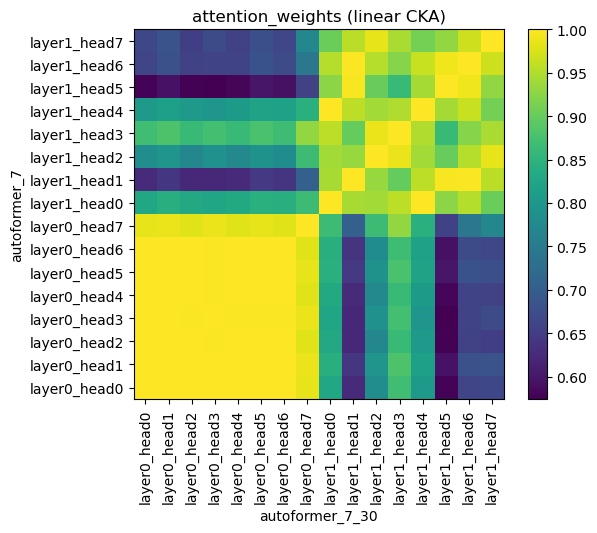

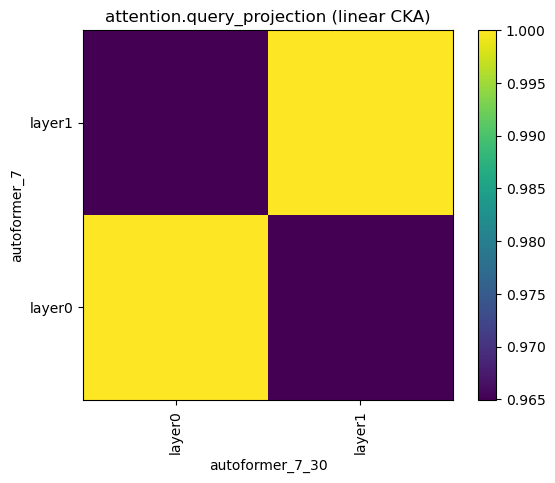

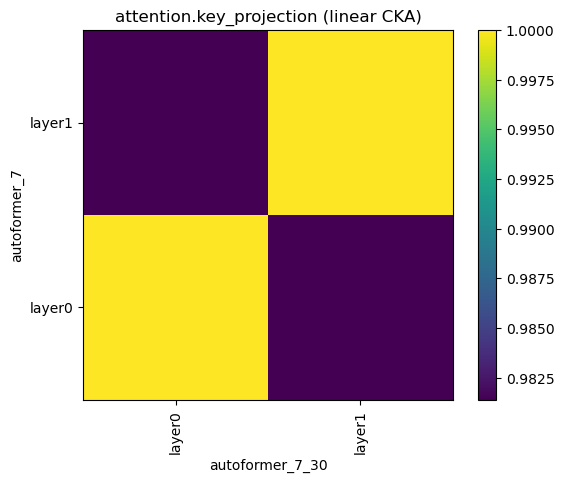

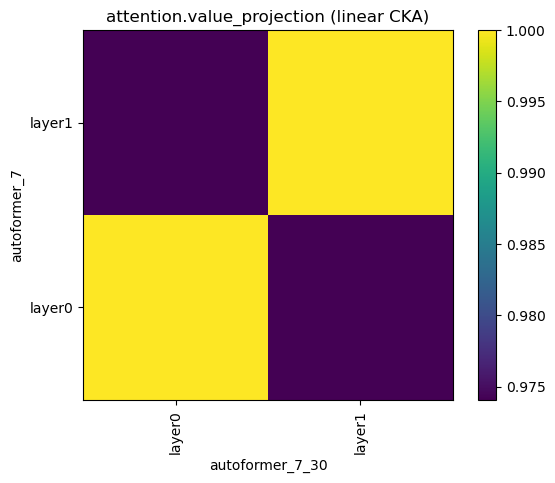

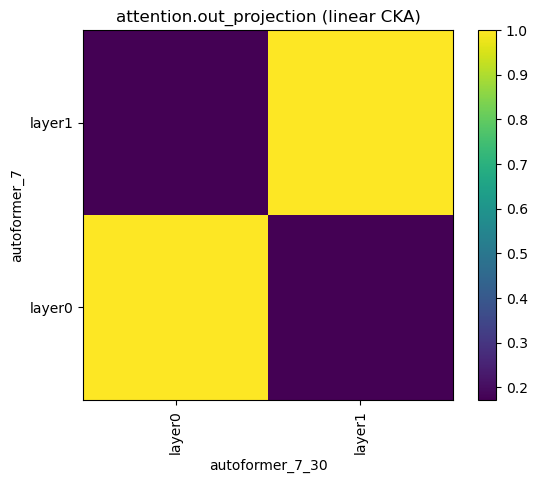

In [48]:
data_loader_7 = obtain_data_loader(pred_len=96, dataset="sinus7")

for stimulus7 in data_loader_7:
    seq_x, seq_y, seq_x_mark, seq_y_mark = stimulus7
    print(seq_x.shape)
    print(seq_y.shape)
    print(seq_x_mark.shape)
    print(seq_y_mark.shape)
    plt.figure()
    plt.plot(seq_x[0, :, -1])
    plt.suptitle("stimulus")
    break


autoformer_7_v1 = obtain_autoformer(pred_len=96, dataset="sinus7")
autoformer_7_v2 = obtain_autoformer(pred_len=96, dataset="seed2021_sinus7")

activations_7_v1 = get_activations_for_dataset(
    model=autoformer_7_v1, stimuli=[stimulus7]
)
activations_7_v2 = get_activations_for_dataset(
    model=autoformer_7_v2, stimuli=[stimulus7]
)

scores, descriptions, modelnames = obtain_CKA_heatmaps_layerwise(
    activations_7_v1,
    activations_7_v2,
    modelnames=["autoformer_v1", "autoformer_v2"],
    type="linear",
)
plot_CKA_heatmaps(scores, descriptions, modelnames, type="linear")

Follow-up sanity check: If we compare the same activations, we should see that the same heads are always similar. And ideally, there should not be difference between the literal same activations and activations of two models trained on the same data with the same seed.

torch.Size([1, 96, 1])
torch.Size([1, 144, 1])
torch.Size([1, 96, 4])
torch.Size([1, 144, 4])
start []
start []
[{'value_vectors': defaultdict(<class 'list'>, {}), 'individual_heads': defaultdict(<class 'list'>, {}), 'attention_weights': defaultdict(<class 'list'>, {}), 'attention.query_projection': defaultdict(<class 'list'>, {}), 'attention.key_projection': defaultdict(<class 'list'>, {}), 'attention.value_projection': defaultdict(<class 'list'>, {}), 'attention.out_projection': defaultdict(<class 'list'>, {})}]
start with component:  value_vectors
 layer:  0
 shape:  (96, 8, 64)
 layer:  1
 shape:  (96, 8, 64)
start with component:  individual_heads
 layer:  0
 shape:  (96, 8, 64)
 layer:  1
 shape:  (96, 8, 64)
start with component:  attention_weights
 layer:  0
 shape:  (96, 8, 64)
 layer:  1
 shape:  (96, 8, 64)
start with component:  attention.query_projection
 layer:  0
 shape:  (96, 512)
 layer:  1
 shape:  (96, 512)
start with component:  attention.key_projection
 layer:  0
 

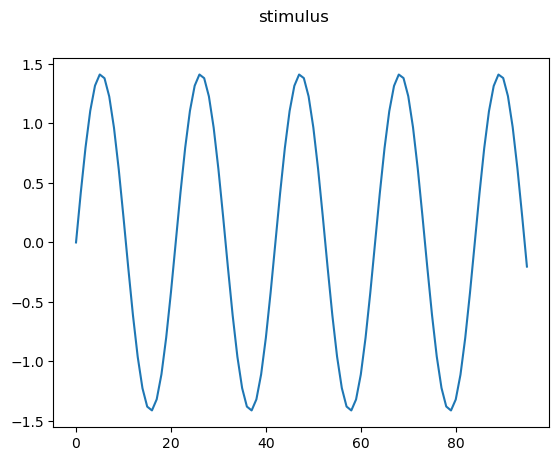

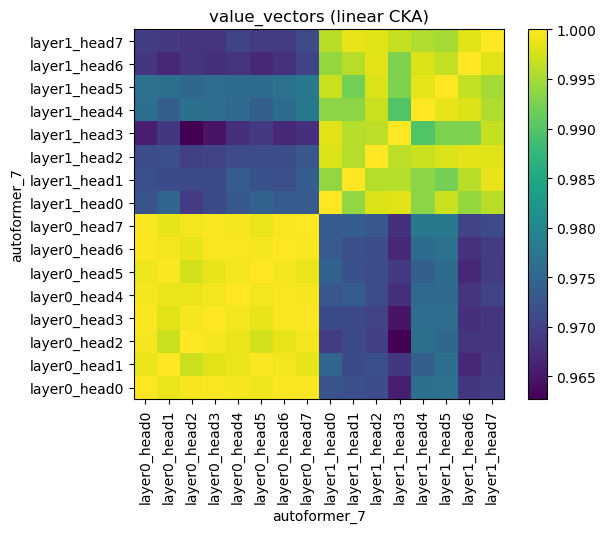

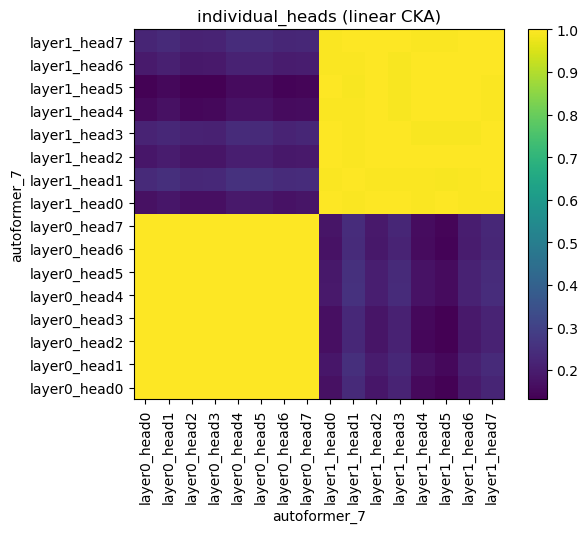

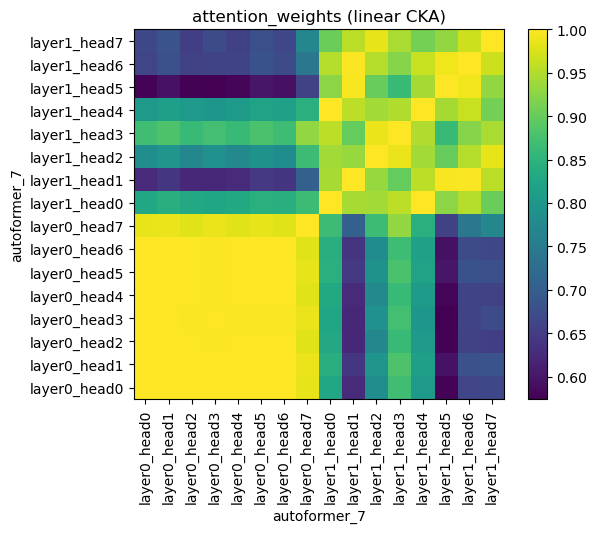

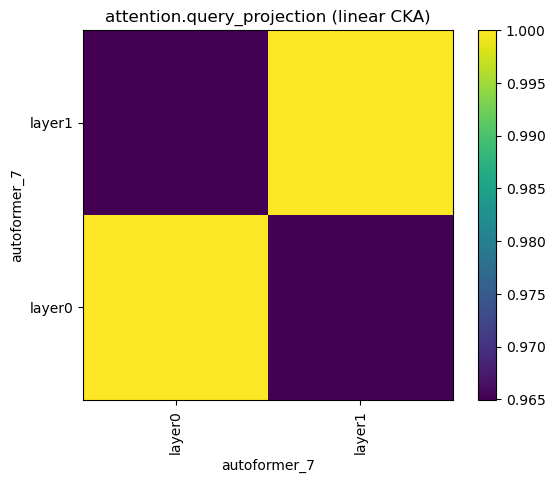

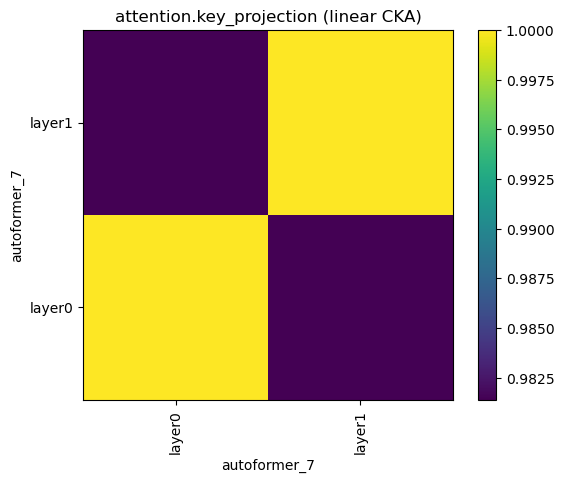

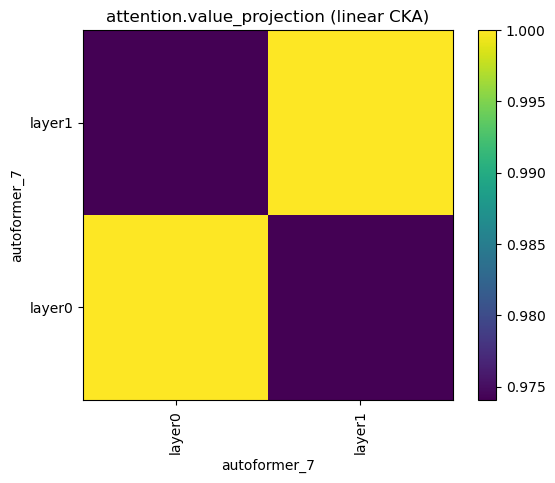

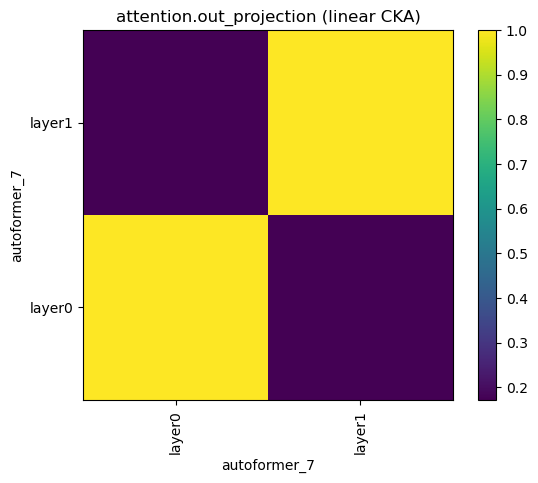

In [49]:
data_loader_7 = obtain_data_loader(pred_len=96, dataset="sinus7")

for stimulus7 in data_loader_7:
    seq_x, seq_y, seq_x_mark, seq_y_mark = stimulus7
    print(seq_x.shape)
    print(seq_y.shape)
    print(seq_x_mark.shape)
    print(seq_y_mark.shape)
    plt.figure()
    plt.plot(seq_x[0, :, -1])
    plt.suptitle("stimulus")
    break


autoformer_7_v1 = obtain_autoformer(pred_len=96, dataset="sinus7")
# autoformer_7_v2 = obtain_autoformer(pred_len=96, dataset="seed2021_sinus7")

activations_7_v1 = get_activations_for_dataset(
    model=autoformer_7_v1, stimuli=[stimulus7]
)
# activations_7_v2 = get_activations_for_dataset(
#     model=autoformer_7_v2, stimuli=[stimulus7]
# )

scores, descriptions, modelnames = obtain_CKA_heatmaps_layerwise(
    activations_7_v1,
    activations_7_v1,
    modelnames=["autoformer_7", "autoformer_7"],
    type="linear",
)
plot_CKA_heatmaps(scores, descriptions, modelnames, type="linear")

Question: Are there components that act similar for all data of that frequency? I.e. are there components that are always active when a specific frequency is present?
Answer (from plots below): perhaps, we see that layer1_head5 is pretty similar when we evaluate autoformer trained on 7+30 data on 7 data and on 7+30 data. However, this autoformer does not really perform well on the data it is not trained on.

torch.Size([1, 96, 1])
torch.Size([1, 144, 1])
torch.Size([1, 96, 4])
torch.Size([1, 144, 4])
torch.Size([1, 96, 1])
torch.Size([1, 144, 1])
torch.Size([1, 96, 4])
torch.Size([1, 144, 4])
start []
start []
[{'value_vectors': defaultdict(<class 'list'>, {}), 'individual_heads': defaultdict(<class 'list'>, {}), 'attention_weights': defaultdict(<class 'list'>, {}), 'attention.query_projection': defaultdict(<class 'list'>, {}), 'attention.key_projection': defaultdict(<class 'list'>, {}), 'attention.value_projection': defaultdict(<class 'list'>, {}), 'attention.out_projection': defaultdict(<class 'list'>, {})}]
start []
start []
[{'value_vectors': defaultdict(<class 'list'>, {}), 'individual_heads': defaultdict(<class 'list'>, {}), 'attention_weights': defaultdict(<class 'list'>, {}), 'attention.query_projection': defaultdict(<class 'list'>, {}), 'attention.key_projection': defaultdict(<class 'list'>, {}), 'attention.value_projection': defaultdict(<class 'list'>, {}), 'attention.out_project

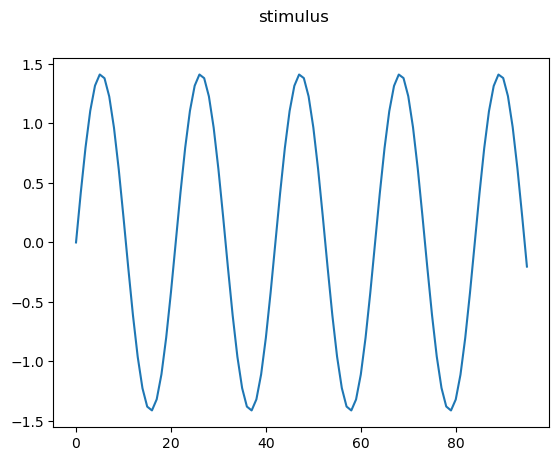

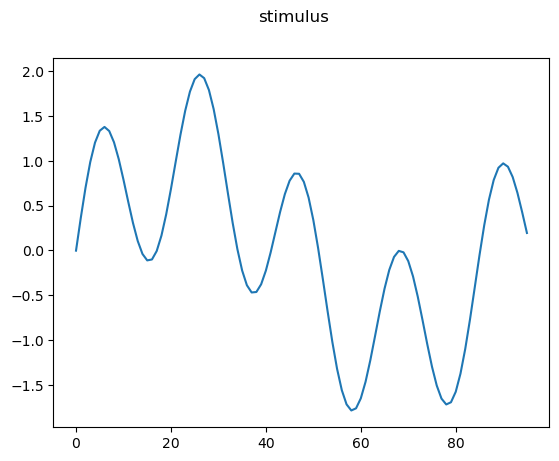

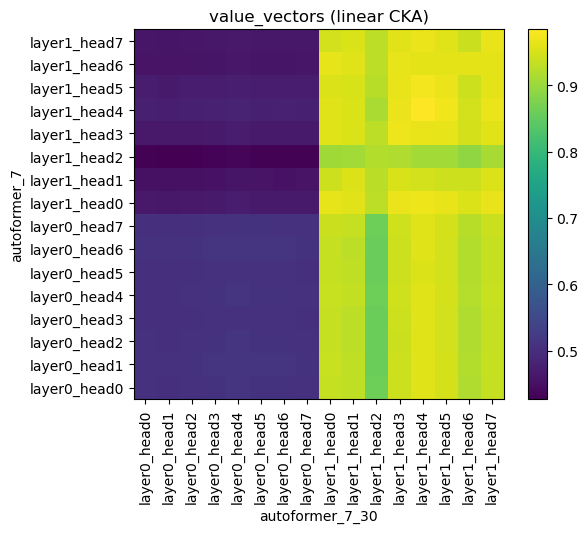

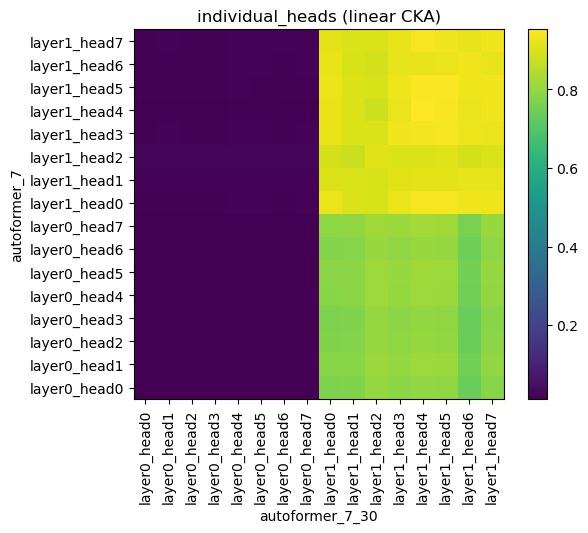

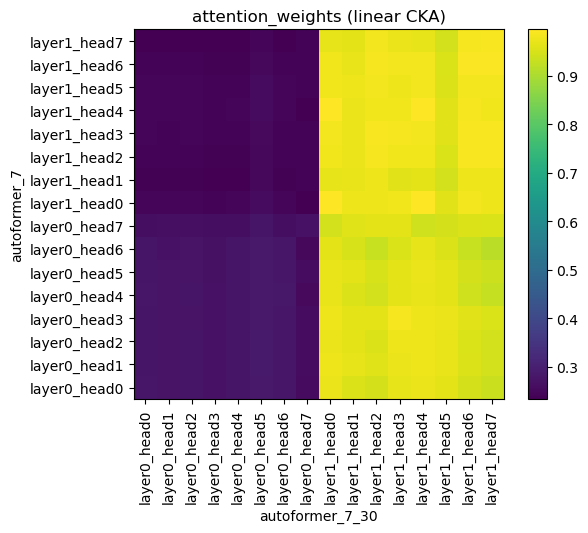

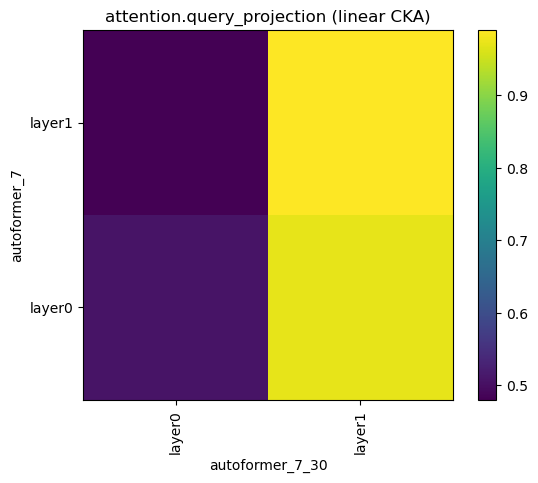

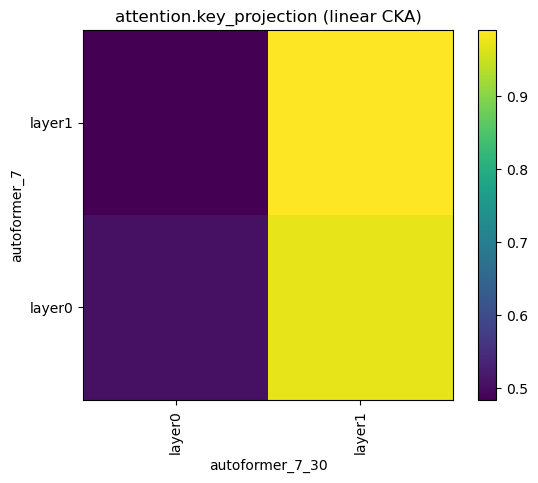

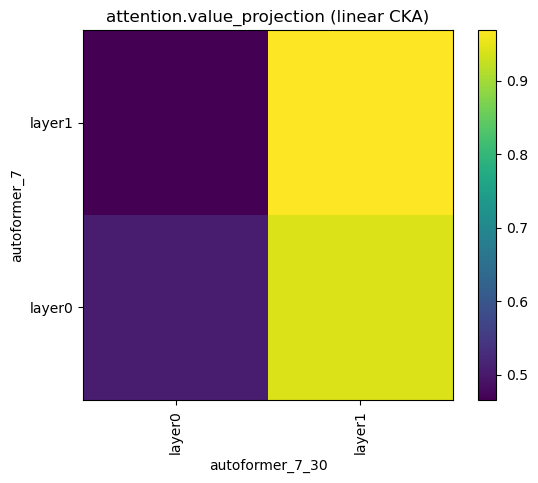

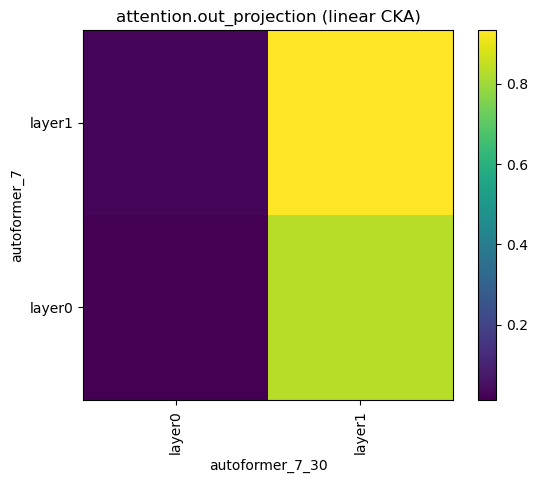

In [ ]:
data_loader_7 = obtain_data_loader(pred_len=96, dataset="sinus7")
data_loader_7_30 = obtain_data_loader(pred_len=96, dataset="sinus7+sinus30")

for stimulus7 in data_loader_7:
    seq_x, seq_y, seq_x_mark, seq_y_mark = stimulus7
    print(seq_x.shape)
    print(seq_y.shape)
    print(seq_x_mark.shape)
    print(seq_y_mark.shape)
    plt.figure()
    plt.plot(seq_x[0, :, -1])
    plt.suptitle("stimulus")
    break

for stimulus730 in data_loader_7_30:
    seq_x, seq_y, seq_x_mark, seq_y_mark = stimulus730
    print(seq_x.shape)
    print(seq_y.shape)
    print(seq_x_mark.shape)
    print(seq_y_mark.shape)
    plt.figure()
    plt.plot(seq_x[0, :, -1])
    plt.suptitle("stimulus")
    break

autoformer_7 = obtain_autoformer(pred_len=96, dataset="sinus7")
autoformer_7_30 = obtain_autoformer(pred_len=96, dataset="sinus7+sinus30")

activations_7 = get_activations_for_dataset(model=autoformer_7_30, stimuli=[stimulus7])
activations_7_30 = get_activations_for_dataset(
    model=autoformer_7_30, stimuli=[stimulus730]
)

scores, descriptions, modelnames = obtain_CKA_heatmaps_layerwise(
    activations_7,
    activations_7_30,
    modelnames=["autoformer_7", "autoformer_7_30"],
    type="linear",
)
plot_CKA_heatmaps(scores, descriptions, modelnames, type="linear")

Question: we are interested in comparing different models with each other, so now let's compare the activations of two models (one trained on 7 data and one trained on 7+30 data), if they have sort of similar activations on the same data, then the other finetuned model has retained some of its functionality.

torch.Size([1, 96, 1])
torch.Size([1, 144, 1])
torch.Size([1, 96, 4])
torch.Size([1, 144, 4])
start []
start []
[{'value_vectors': defaultdict(<class 'list'>, {}), 'individual_heads': defaultdict(<class 'list'>, {}), 'attention_weights': defaultdict(<class 'list'>, {}), 'attention.query_projection': defaultdict(<class 'list'>, {}), 'attention.key_projection': defaultdict(<class 'list'>, {}), 'attention.value_projection': defaultdict(<class 'list'>, {}), 'attention.out_projection': defaultdict(<class 'list'>, {})}]
start []
start []
[{'value_vectors': defaultdict(<class 'list'>, {}), 'individual_heads': defaultdict(<class 'list'>, {}), 'attention_weights': defaultdict(<class 'list'>, {}), 'attention.query_projection': defaultdict(<class 'list'>, {}), 'attention.key_projection': defaultdict(<class 'list'>, {}), 'attention.value_projection': defaultdict(<class 'list'>, {}), 'attention.out_projection': defaultdict(<class 'list'>, {})}]
start with component:  value_vectors
 layer:  0
 shape

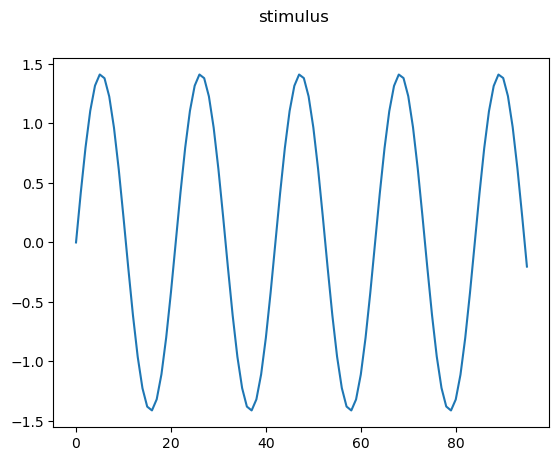

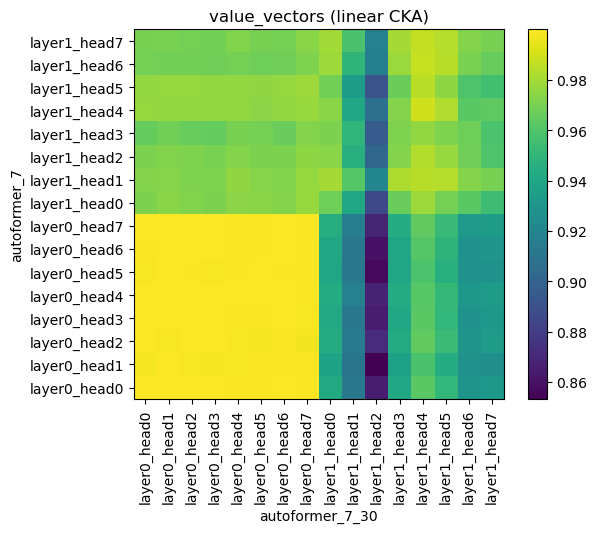

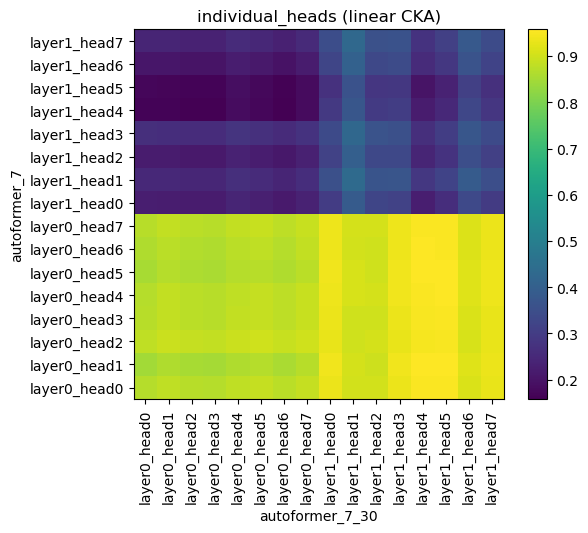

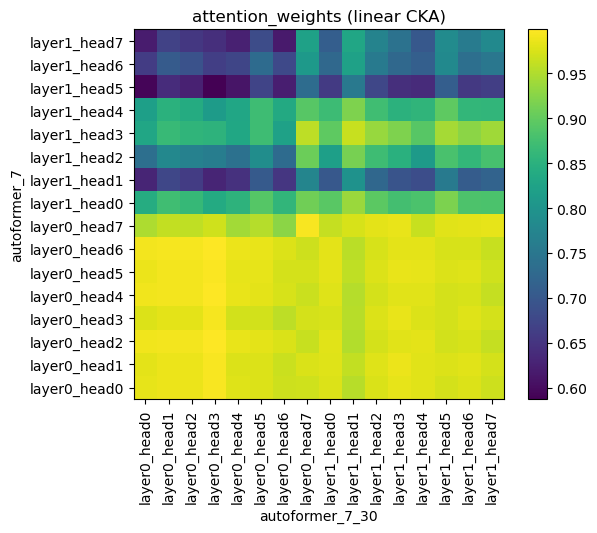

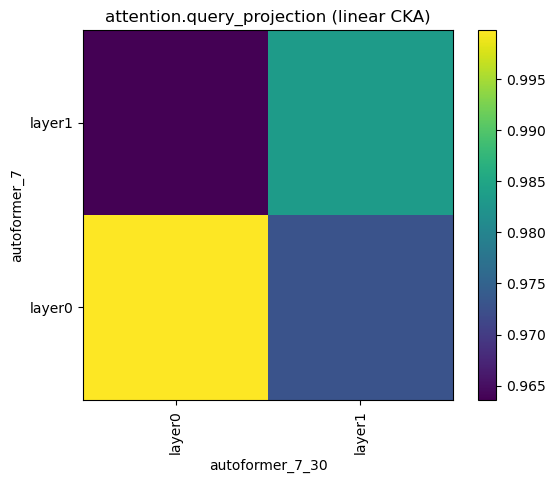

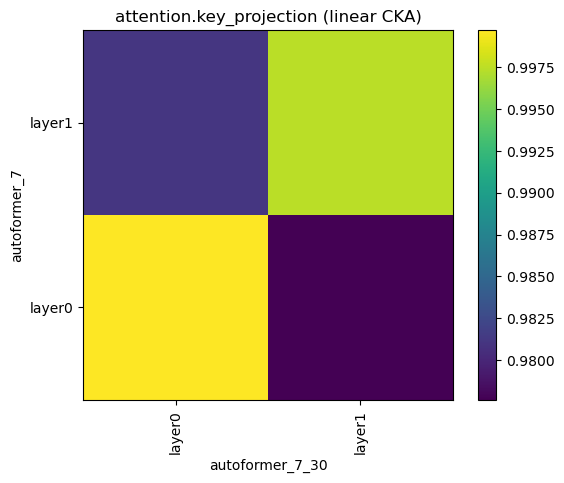

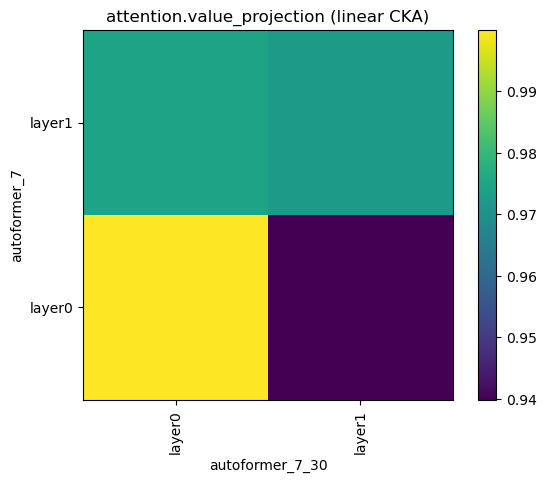

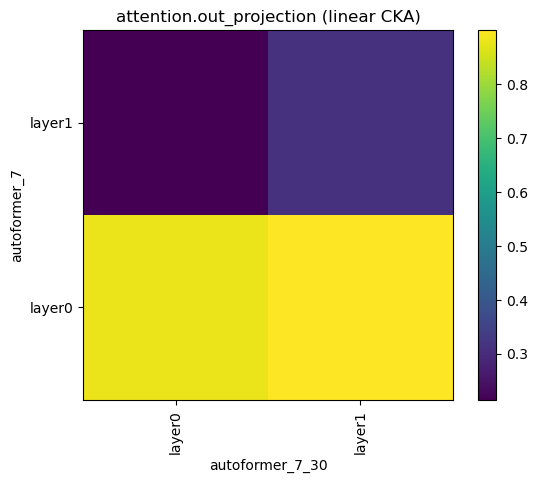

In [ ]:
data_loader_7 = obtain_data_loader(pred_len=96, dataset="sinus7")

for stimulus7 in data_loader_7:
    seq_x, seq_y, seq_x_mark, seq_y_mark = stimulus7
    print(seq_x.shape)
    print(seq_y.shape)
    print(seq_x_mark.shape)
    print(seq_y_mark.shape)
    plt.figure()
    plt.plot(seq_x[0, :, -1])
    plt.suptitle("stimulus")
    break


autoformer_7 = obtain_autoformer(pred_len=96, dataset="sinus7")
autoformer_7_30 = obtain_autoformer(pred_len=96, dataset="sinus7+sinus30")

activations_7 = get_activations_for_dataset(model=autoformer_7, stimuli=[stimulus7])
activations_7_30 = get_activations_for_dataset(
    model=autoformer_7_30, stimuli=[stimulus7]
)

scores, descriptions, modelnames = obtain_CKA_heatmaps_layerwise(
    activations_7,
    activations_7_30,
    modelnames=["autoformer_7", "autoformer_7_30"],
    type="linear",
)
plot_CKA_heatmaps(scores, descriptions, modelnames, type="linear")